# XGBoost Exploration

## Introduction
In this report, we explored using XGBoost to search for features associated with breast cancer in UKB.

## Data

Total dataset contains data for 104313 post-menopausal participants after exclusion criteria. After train-test split, training data has 83450 people (80%) and test data has 20863 people (20%).

We started with 2330 features. After removing features with 0 counts and missing > 30% **based on training data** (not test data), we ended up with 1737 features. 

Then to train XGBoost model, we OneHotEncoded the input data (i.e. transform categorical variables into dummy indicators), which led to 3046 columns.

In [7]:
import os 
import yaml
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.inspection import permutation_importance
import time
from sklearn.model_selection import KFold
from copy import deepcopy
from itertools import product
from collections import defaultdict
import graphviz 
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 12
import json
import shap
import pickle

#os.chdir(os.path.dirname(__file__))
os.chdir("K:\\TEU\\TEU_Members\\Xiaonan_Liu\\Projects\\prsonbrstcancer")

with open('config.yml') as f:
    # use safe_load instead load
    config = yaml.safe_load(f)


tot_train=pd.read_feather("Data/Derived/tot_train.feather")
tot_test=pd.read_feather("Data/Derived/tot_test.feather")

# Load pretty_names list from R
with open(config['data']['derived']+'/full_pretty_names.json', 'r') as myfile:
    data=myfile.read()

pretty_names=json.loads(data)

pretty_names = {k:v[0] for k,v in pretty_names.items()}

pretty_names['TEU_BrCa_313_PRS']="$PRS_{313}$"
pretty_names['TEU_BrCa_100k_PRS']="$PRS_{120k}$"
pretty_names['TEU_FaH_BrCa_Family history of BrCa']="Family history of BrCa"

In [2]:
# OneHotEncode input features

predictors=[x for x in tot_train.columns if x not in ["TEU_BrCa_time","TEU_BrCa_status","ID","Uri_MicroAlbFlag","OtherCancerDx_Prevalent","GeP_Array"]+["GeP_PC_"+str(num1) for num1 in range(1,11)]]

# Separate out numerical and categorical
categorical_columns=tot_train[predictors].select_dtypes(include="category").columns
numerical_columns=tot_train[predictors].select_dtypes(include="float64").columns


ohe = OneHotEncoder(categories="auto", 
                    sparse=False, handle_unknown="ignore")


column_trans=ColumnTransformer([("cat",ohe,categorical_columns)],remainder="passthrough")

# We'd need to fit on training set
column_trans.fit(tot_train[predictors])

dtrain=column_trans.transform(tot_train[predictors]) #gives numpy.array
# The order of dtrain is first transformed categorical, then numerical vars

Y=tot_train['TEU_BrCa_status']


print("Training features shape: ", tot_train[predictors].shape)
print("dtrain shape: ",dtrain.shape)


Training features shape:  (83450, 1737)
dtrain shape:  (83450, 3046)


In [6]:
# OHE on test set

# Transform test set using info from training 
dtest=column_trans.transform(tot_test[predictors])

Ytest=tot_test['TEU_BrCa_status']

print("Test features shape: ", tot_test[predictors].shape)
print("dtest shape: ",dtest.shape)

Test features shape:  (20863, 1737)
dtest shape:  (20863, 3046)


## Step 1: Build baseline model 

At this stage, we'd like to build a baseline mdel with a low learning rate (0.1) to get a rough sense of the trees needed. With incorporation of early stopping, we found 150 trees was sufficient at this stage.

The outcome used is binary (Y/N for breast cancer indicator), hence we treated it as a classification problem and train models to minimise log-loss.

In [ ]:
# XGBoost model:
# Step 1: build a baseline model
# Main aim is to see the rough range of trees needed.

# baseline model
xgb_baseline=XGBClassifier(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    reg_lambda=1, #Similar to Ridge
    reg_alpha=0,
    objective= 'binary:logistic',
    use_label_encoder=False,
    random_state=0
)

## Ran into memory issue for 5 folds, and 3 folds is taking more than 30min
# Since we just want a rough number of trees needed, hence use early stopping instead.

seed = 7
test_size = 0.3
Trees_train, Trees_val, y_train, y_val = train_test_split(dtrain, Y, 
test_size=test_size, random_state=seed)
eval_set = [(Trees_val, y_val)]

xgb_baseline.fit(Trees_train,y_train,early_stopping_rounds=50,eval_metric="auc",
eval_set=eval_set,verbose=True)

## Step 2: Tune max_depth and min_child_weight

min_child_weight prevents a specific sample selected for a tree. Higher the value, the more conservative the model. We found that max_dpeth=2 is the optimal.

In [ ]:
# Step 2: Tune max_depth and min_child_weight
# Ran on BMRC
param_test1 = {
 'max_depth':range(1,8,1),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,use_label_encoder=False), 
 param_grid = param_test1, scoring='roc_auc', cv=5)
gsearch1.fit(dtrain,Y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


joblib.dump(gsearch1, 'Data/Derived/gsearch1.pkl')

In [8]:
# Load results
gsearch1=joblib.load(config['data']['derived']+'/gsearch1.pkl')

gresearch1_df=pd.DataFrame({'max_depth': gsearch1.cv_results_["param_max_depth"],
 'min_child_weight': gsearch1.cv_results_["param_min_child_weight"],
 'acc': gsearch1.cv_results_["mean_test_score"]})

print(gresearch1_df.sort_values(by=['acc'],ascending=False)) 

   max_depth min_child_weight       acc
4          2                3  0.662313
5          2                5  0.662271
3          2                1  0.661812
2          1                5  0.661535
0          1                1  0.661470
1          1                3  0.661470
8          3                5  0.656547
7          3                3  0.656513
6          3                1  0.655632
11         4                5  0.655402
9          4                1  0.651567
10         4                3  0.651367
14         5                5  0.645789
13         5                3  0.645447
12         5                1  0.644677
15         6                1  0.640480
16         6                3  0.637086
17         6                5  0.634839
20         7                5  0.632533
19         7                3  0.630880
18         7                1  0.630416


## Step 3: Tune gamma
gamma is the minimum loss reduction required to make a split. The higher Gamma is, the higher the regularization. Default value is 0.8.

In [ ]:
# Step 3: Tune gamma
# Ran on BMRC
param_test2 = {
 'gamma':[i/10.0 for i in range(0,12,2)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=2,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,use_label_encoder=False), 
 param_grid = param_test2, scoring='roc_auc', cv=5)
gsearch2.fit(dtrain,Y)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

joblib.dump(gsearch2, 'Data/Derived/gsearch2.pkl')

In [ ]:
# Double check on gamma
# Ran on BMRC
param_test2a = {
 'gamma':[0.8,1.4,1.6]
}
gsearch2a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=2,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,use_label_encoder=False), 
 param_grid = param_test2a, scoring='roc_auc', cv=5)
gsearch2a.fit(dtrain,Y)

joblib.dump(gsearch2a, 'Data/Derived/gsearch2a.pkl')

In [12]:
gsearch2=joblib.load(config['data']['derived']+'/gsearch2.pkl')
gsearch2a=joblib.load(config['data']['derived']+'/gsearch2a.pkl')

gsearch2_df=pd.DataFrame({
 'gamma': gsearch2.cv_results_["param_gamma"],
 'acc': gsearch2.cv_results_["mean_test_score"]})

gsearch2a_df=pd.DataFrame({
 'gamma': gsearch2a.cv_results_["param_gamma"],
 'acc': gsearch2a.cv_results_["mean_test_score"]})


gsearch2_total=gsearch2_df.append(gsearch2a_df,ignore_index=True).drop_duplicates(subset=['gamma'])
print(gsearch2_total.sort_values(by=['acc'],ascending=False))


#print(gsearch2a_df.sort_values(by=['acc'],ascending=False)) 

#print(gsearch2_df.sort_values(by=['acc'],ascending=False)) 

  gamma       acc
4   0.8  0.662331
5   1.0  0.662331
0   0.0  0.662313
1   0.2  0.662313
2   0.4  0.662313
3   0.6  0.662313
7   1.4  0.662065
8   1.6  0.662065


## Step 4: Tune subsample and colsample_bytree

subsample is the fraction of observation to be randomly samples for each tree. And colsample_bytree is the fraction of columns to be randomly samples for each tree.

In [ ]:
# Step 4: Tune subsample and colsample_bytree
# Ran on BMRC
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=2,
 min_child_weight=3, gamma=gsearch2a_df.sort_values(by=['acc'],ascending=False).iloc[0]['gamma'], subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,use_label_encoder=False), 
 param_grid = param_test3, scoring='roc_auc', cv=5)

gsearch3.fit(dtrain,Y)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_


joblib.dump(gsearch3, 'Data/Derived/gsearch3.pkl')

In [14]:
# Load results
gsearch3=joblib.load(config['data']['derived']+'/gsearch3.pkl')

gsearch3_df=pd.DataFrame({'subsample': gsearch3.cv_results_["param_subsample"],
 'colsample_bytree': gsearch3.cv_results_["param_colsample_bytree"],
 'acc': gsearch3.cv_results_["mean_test_score"]})

print(gsearch3_df.sort_values(by=['acc'],ascending=False))

   subsample colsample_bytree       acc
14       0.8              0.9  0.664078
11       0.9              0.8  0.663689
8        0.6              0.8  0.663498
3        0.9              0.6  0.663128
15       0.9              0.9  0.662946
0        0.6              0.6  0.662910
9        0.7              0.8  0.662449
10       0.8              0.8  0.662331
7        0.9              0.7  0.662110
4        0.6              0.7  0.662058
5        0.7              0.7  0.662022
2        0.8              0.6  0.661995
12       0.6              0.9  0.661876
1        0.7              0.6  0.661552
6        0.8              0.7  0.661436
13       0.7              0.9  0.661376


## Step 5: Tune regularization parameters 

We are tuning lambda for regularization, analogous to Ridge regression.

In [ ]:
# Step 5: Tune regularization parameters
# Ran on BMRC
param_test4={
    'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=2,
 min_child_weight=3, gamma=0.8, subsample=0.8, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,use_label_encoder=False), 
 param_grid = param_test4, scoring='roc_auc', cv=5)

gsearch4.fit(dtrain,Y)

gsearch4_df=pd.DataFrame({
 'reg_lambda': gsearch4.cv_results_["param_reg_lambda"],
 'acc': gsearch4.cv_results_["mean_test_score"]})

print(gsearch4_df.sort_values(by=['acc'],ascending=False))

joblib.dump(gsearch4, 'Data/Derived/gsearch4.pkl')

More detailed search for lambda:

In [ ]:
# More detailed tuning on regularization parameters
# Ran on BMRC
param_test4a={
    'reg_lambda':[0.5,1,5,10]
}

gsearch4a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=2,
 min_child_weight=3, gamma=0.8, subsample=0.8, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,use_label_encoder=False), 
 param_grid = param_test4a, scoring='roc_auc', cv=5)

gsearch4a.fit(dtrain,Y)

gsearch4a_df=pd.DataFrame({
 'reg_lambda': gsearch4a.cv_results_["param_reg_lambda"],
 'acc': gsearch4a.cv_results_["mean_test_score"]})
 
print(gsearch4a_df.sort_values(by=['acc'],ascending=False))


joblib.dump(gsearch4a, 'Data/Derived/gsearch4a.pkl')

In [ ]:
# More detailed tuning on regularization parameters
# Ran on BMRC
param_test4b={
    'reg_lambda':[8,10,12,14,16]
}

gsearch4b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=2,
 min_child_weight=3, gamma=0.8, subsample=0.8, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,use_label_encoder=False), 
 param_grid = param_test4b, scoring='roc_auc', cv=5)

gsearch4b.fit(dtrain,Y)

gsearch4b_df=pd.DataFrame({
 'reg_lambda': gsearch4b.cv_results_["param_reg_lambda"],
 'acc': gsearch4b.cv_results_["mean_test_score"]})
 
print(gsearch4b_df.sort_values(by=['acc'],ascending=False))


joblib.dump(gsearch4b, 'Data/Derived/gsearch4b.pkl')

In [ ]:
# More detailed tuning on regularization parameters
# Ran on BMRC
param_test4c={
    'reg_lambda':[16,18,20,22]
}

gsearch4c = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=2,
 min_child_weight=3, gamma=0.8, subsample=0.8, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,use_label_encoder=False), 
 param_grid = param_test4c, scoring='roc_auc', cv=5)

gsearch4c.fit(dtrain,Y)

gsearch4c_df=pd.DataFrame({
 'reg_lambda': gsearch4c.cv_results_["param_reg_lambda"],
 'acc': gsearch4c.cv_results_["mean_test_score"]})
 
print(gsearch4c_df.sort_values(by=['acc'],ascending=False))


joblib.dump(gsearch4c, 'Data/Derived/gsearch4c.pkl')

In [18]:
suffix=['','a','b','c']

gsearch4_total=[]

for i in suffix:
    gsearch=joblib.load(config['data']['derived']+'/gsearch4'+i+'.pkl')
    gsearch_df=pd.DataFrame({
 'reg_lambda': gsearch.cv_results_["param_reg_lambda"],
 'acc': gsearch.cv_results_["mean_test_score"]})
    
    gsearch4_total.append(gsearch_df)


gsearch4_total=pd.concat(gsearch4_total)

print(gsearch4_total.sort_values(by=['acc'],ascending=False))

  reg_lambda       acc
1         18  0.664959
0         16  0.664738
4         16  0.664738
3         14  0.664733
2         20  0.664652
0          8  0.664365
3         22  0.664201
3         10  0.664131
1         10  0.664131
1          1  0.664078
3          1  0.664078
2         12  0.664063
2          5  0.663527
4        100  0.663483
0    0.00001  0.662417
2        0.1  0.662341
0        0.5  0.662040
1       0.01  0.661823


# Step 6: scale_pos_weight
Control the balance of positive and negative weights, useful for unbalanced calsses. A typical value to consider is number of negative instances divided by number of positive instances.

In [ ]:
# Step 6 Tune scale_pos_weight
# Ran on BMRC
param_test5={
    'scale_pos_weight':[1,25,100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=2,
 min_child_weight=3, gamma=0.8, subsample=0.8, colsample_bytree=0.9,reg_lambda=18,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,use_label_encoder=False), 
 param_grid = param_test5, scoring='roc_auc', cv=5)

gsearch5.fit(dtrain,Y)


joblib.dump(gsearch5, 'Data/Derived/gsearch5.pkl')

In [19]:
gsearch5=joblib.load(config['data']['derived']+'/gsearch5.pkl')

gsearch5_df=pd.DataFrame({
 'scale_pos_weight': gsearch5.cv_results_["param_scale_pos_weight"],
 'acc': gsearch5.cv_results_["mean_test_score"]})

print(gsearch5_df.sort_values(by=['acc'],ascending=False))

  scale_pos_weight       acc
0                1  0.664959
1               25  0.660900
2              100  0.654338


## Step 7: Lower learning rate 

At this step, we incorporated early stopping with gridsearchcv. This way, we would save computation time, get more accurate number of trees needed and potential increase in model performance.

In [ ]:
# GridSearchCV with Early stopping, copied from 
# https://www.kaggle.com/yantiz/xgboost-gridsearchcv-with-early-stopping-supported/notebook

# Made some tweaks on removing scorer and what to return

def GridSearchCV_XGB_early_stoppping(param_grid, fit_params, cv, X, y):
    """This function performs grid search for the best set of parameters of XGBoost model with early stopping.

    Args:
        param_grid (dict): The parameter ranges for which the function searches.
        fit_params (dict): The fitting parameters for XGBoost.
        cv (model_selection._split): The sklearn's split instance.
        X (DataFrame): The input data matrix.
        y (Series): The ground truth label.
        
    Returns:
        dict: The best set of parameters found via grid search.
    """
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()
        
    param_names, param_values = zip(*list(param_grid.items()))

    cv_best_iterations = defaultdict(list)
    cv_results = defaultdict(list)

    for train_index, test_index in cv.split(X, y):
        X_in, X_out = X[train_index], X[test_index]
        y_in, y_out = y[train_index], y[test_index]

        fit_params_cv = deepcopy(fit_params)
        fit_params_cv['eval_set'] = [(X_out, y_out)]

        for value_combination in product(*param_values):
            param_grid_cv = tuple(zip(param_names, value_combination))
            xgboost = XGBClassifier(**dict(param_grid_cv))

            xgboost.fit(X_in, y_in, **fit_params_cv)
            best_iteration = xgboost.get_num_boosting_rounds() if 'early_stopping_rounds' not in fit_params_cv else xgboost.best_iteration
            cv_best_iterations[param_grid_cv].append(best_iteration)

            score = xgboost.best_score # XL change
            cv_results[param_grid_cv].append(score)
        
    best_params_xgb, score_list = max(cv_results.items(), key=lambda x: np.array(x[1]).mean())

    # Note that our XGBoost model may stop early,
    # so we calculate the mean of the actual number of estimators in each fold,
    # in place of the originally planned n_estimators after finishing cross validation.
    n_estimators = int(round(np.array(cv_best_iterations[best_params_xgb]).mean()))
    
    best_params_xgb = dict(best_params_xgb)
    best_params_xgb['n_estimators'] = n_estimators

    print ("Best AUC: {:.3f}".format(np.array(score_list).mean()))
    print ("Best Parameters: {}".format(best_params_xgb))
    
    # XL change: Return both best_params_xgb and score
    output={
    'Best_params':best_params_xgb,
    'Best score':np.array(score_list).mean()
}
    
    return output



In [ ]:
######################################################
# Step 7: Reduce learning rate (also add more trees)
# Ran on BMRC

param_grid={
    'objective': ['binary:logistic'],
    'max_depth': [2],
    'n_estimators': [50000],
    'learning_rate': [0.1,0.01,0.001],
    'min_child_weight': [3],
    'gamma':[0.8],
    'subsample':[0.8],
    'colsample_bytree':[0.9],
    'reg_lambda':[18],
    'scale_pos_weight':[1],
    'random_state': [27],
    'use_label_encoder':[False]
}

fit_params = {
    'eval_metric': "auc",
    'early_stopping_rounds': 200,
    'verbose': True
    
}

#scorer = make_scorer(roc_auc_score, greater_is_better=True)
kf = KFold(n_splits=5, shuffle=True, random_state=27)


# Keep track of the running time
start = time.time()

best_params_xgb = GridSearchCV_XGB_early_stoppping(param_grid, fit_params, kf, dtrain, Y)


end = time.time()

print("--- Grid Search duration in hours: ---" ,round((end-start)/3600,2))


#joblib.dump(gsearch5, 'Data/Derived/gsearch5.pkl')


np.save('Data/Derived/best_params_xgb.npy', best_params_xgb)

## Fit final model

In [3]:
best_params_xgb=np.load(config['data']['derived']+'/best_params_xgb.npy',allow_pickle=True)

print(best_params_xgb)

{'Best_params': {'objective': 'binary:logistic', 'max_depth': 2, 'n_estimators': 1571, 'learning_rate': 0.01, 'min_child_weight': 3, 'gamma': 0.8, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_lambda': 18, 'scale_pos_weight': 1, 'random_state': 27, 'use_label_encoder': False}, 'Best score': 0.6680341999999999}


In [ ]:
# Fit the final model
# Ran on BMRC

xgb_final=XGBClassifier(**best_params_xgb.item()['Best_params'])

xgb_final.fit(dtrain,Y)

# Save model (one way)
xgb_final.save_model("Data/Derived/xgb_final.json")   
# Save model (the other way, better!)
filename = 'Data/Derived/xgb_final.sav'
pickle.dump(xgb_final, open(filename, 'wb'))


In [3]:
# Load model
xgb_final = pickle.load(open(config['data']['derived']+'/xgb_final.sav', 'rb'))


## Visualisation

In [5]:
# Export tree structures
xgb_final.get_booster().dump_model("K:/TEU/MLforBrCa/Stats_Outputs/XGBoost_structure.txt")

In [7]:
ohe_cat=column_trans.named_transformers_["cat"]
feature_names=ohe_cat.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

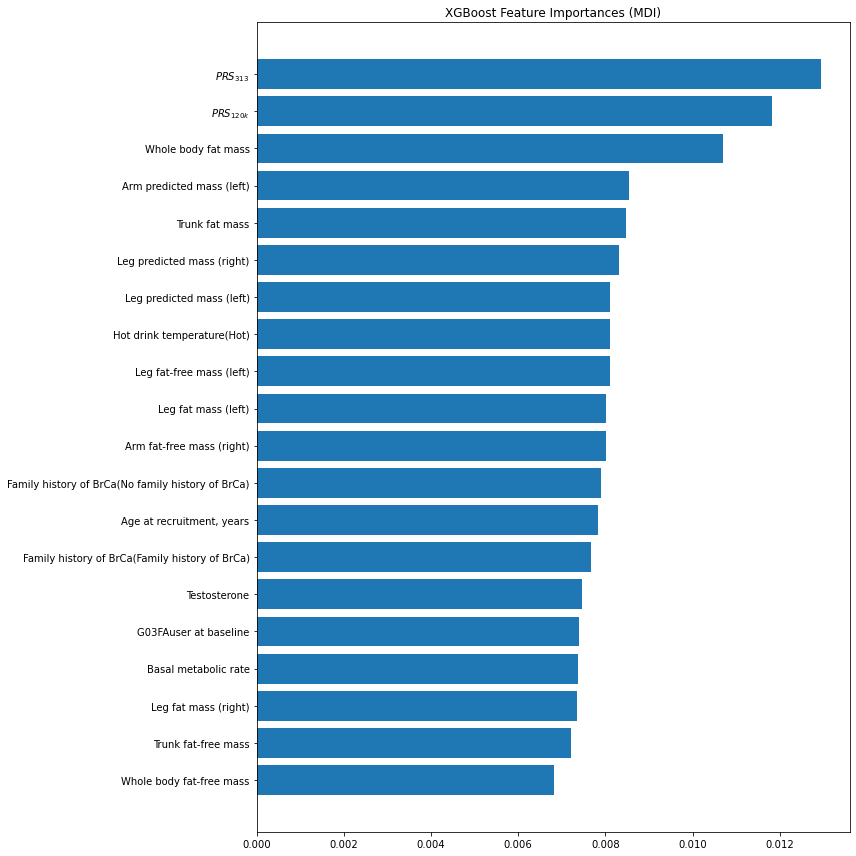

In [4]:
## Results visualisation

# Plot feature importance
# Below is the raw plot
#xgb.plot_importance(xgb_final)

# More pretty version below:

# Change feature_names to the pretty ones
ohe_cat=column_trans.named_transformers_["cat"]
feature_names=ohe_cat.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

pretty_features=np.asarray([pretty_names[var] for var in feature_names])

tree_feature_importances = xgb_final.feature_importances_

num_show=20 # Show how many features on the plot
sorted_idx = tree_feature_importances.argsort()[-num_show:] 

y_ticks = np.arange(0, num_show)
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(pretty_features[sorted_idx])
ax.set_title("XGBoost Feature Importances (MDI)")
fig.tight_layout()
plt.show()


In [27]:
# Export full feature importance to csv

feature_importance_default = pd.DataFrame(list(zip(feature_names,pretty_features,tree_feature_importances)),columns=['Var_name','Full_name','Importance_default'])
feature_importance_default.sort_values(by=['Importance_default'],ascending=False,inplace=True)
feature_importance_default.head()

feature_importance_default.to_csv("K:/TEU/MLforBrCa/Stats_Outputs/XGBoost.csv")

In [ ]:
result=np.load(config['data']['derived']+'/permutation_imp.npy',allow_pickle=True)

test=result.item()['importances_mean']

np.unique(test)

In [ ]:
# Try SHAP values

# Load model

#xgb_final=xgb.Booster()
#xgb_final.load_model(config['data']['derived']+"/xgb_final.json")

explainer = shap.TreeExplainer(xgb_final) # Without specifying data, it would use feature_perturbation="tree_path_dependant" and fast!
shap_values = explainer.shap_values(dtrain)


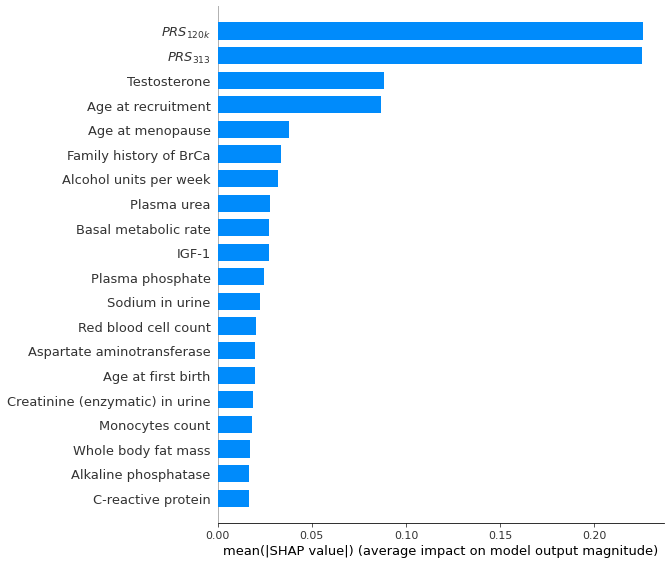

In [8]:

# Get pretty names
ohe_cat=column_trans.named_transformers_["cat"]
feature_names=ohe_cat.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

pretty_features=np.asarray([pretty_names[var] for var in feature_names])

# summary plot
shap.summary_plot(shap_values,pretty_features,plot_type="bar")

In [ ]:

# Get pretty names
ohe_cat=column_trans.named_transformers_["cat"]
feature_names=ohe_cat.get_feature_names(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

pretty_features=np.asarray([pretty_names[var] for var in feature_names])

# summary plot
shap.summary_plot(shap_values,pretty_features,plot_type="bar")

In [29]:
# Export full SHAP to csv
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(feature_names,pretty_features,vals)),columns=['Var_name','Full_name','SHAP'])
feature_importance.sort_values(by=['SHAP'],ascending=False,inplace=True)
feature_importance.head()

feature_importance.to_csv("K:/TEU/MLforBrCa/Stats_Outputs/XGBoost_SHAP.csv")

# SHAP Interactions

In [6]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(feature_names,pretty_features,vals)),columns=['Var_name','Full_name','SHAP'])
feature_importance.sort_values(by=['SHAP'],ascending=False,inplace=True)

feature_importance.head(10)

,Var_name,Full_name,SHAP
2404,TEU_BrCa_100k_PRS,$PRS_{120k}$,0.225993
2403,TEU_BrCa_313_PRS,$PRS_{313}$,0.225588
2530,BBC_TES_Result,Testosterone,0.088389
2402,TEU_BaC_AgeAtRec,"Age at recruitment, years",0.086844
2453,FSF_MenopauseAge,Age at menopause (last menstrual period),0.038097
337,TEU_FaH_BrCa_Family history of BrCa,Family history of BrCa(Family history of BrCa),0.033442
2935,TEU_Alc_WeeklyAlcUnits,Alcohol units per week,0.032000
2514,BBC_BUN_Result,Urea,0.027815
2422,Imp_MetRate,Basal metabolic rate,0.027178
2524,BBC_IGF1_Result,IGF-1,0.026951


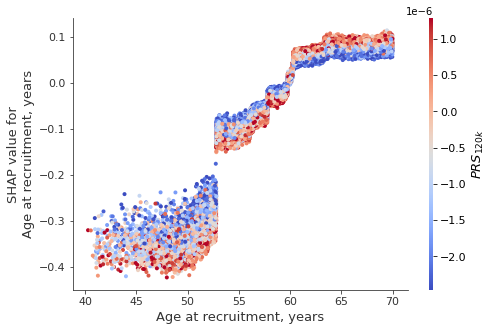

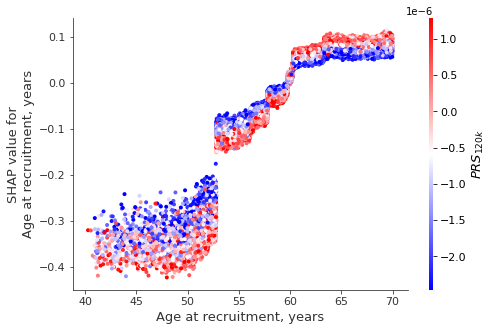

In [73]:
# Try a different colour map for SHAP dependence plot

shap.dependence_plot("Age at recruitment, years", shap_values, dtrain,feature_names=pretty_features,interaction_index='$PRS_{120k}$',cmap=plt.get_cmap("coolwarm"))

shap.dependence_plot("Age at recruitment, years", shap_values, dtrain,feature_names=pretty_features,interaction_index='$PRS_{120k}$',cmap=plt.get_cmap("bwr"))

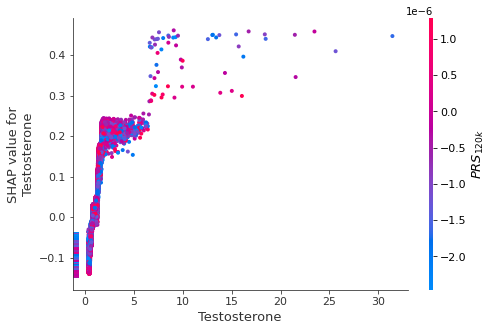

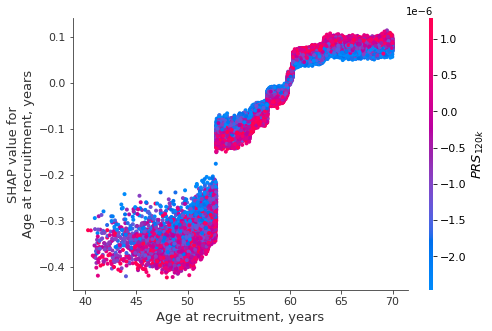

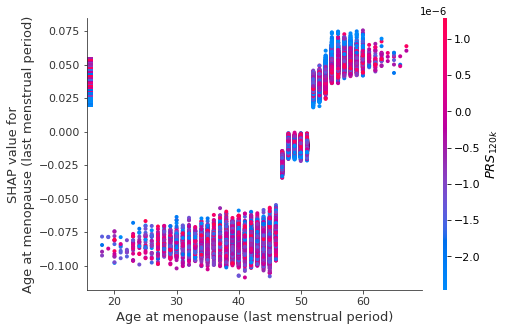

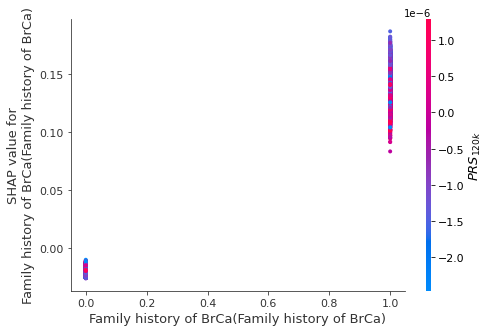

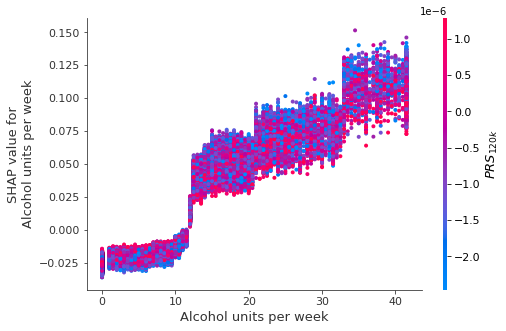

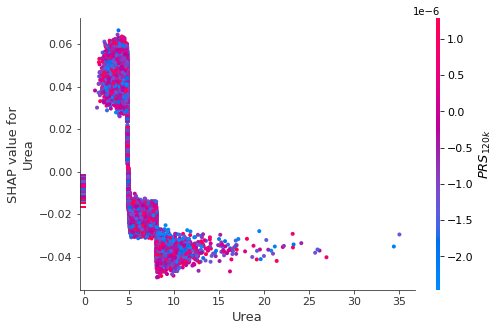

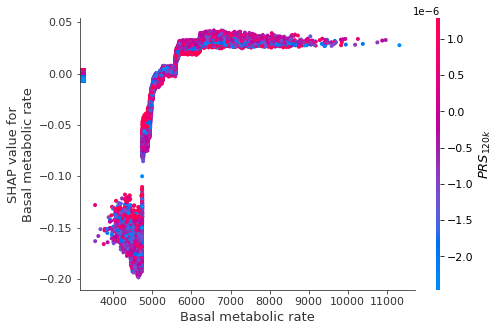

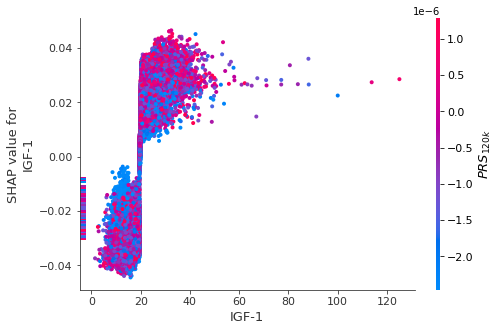

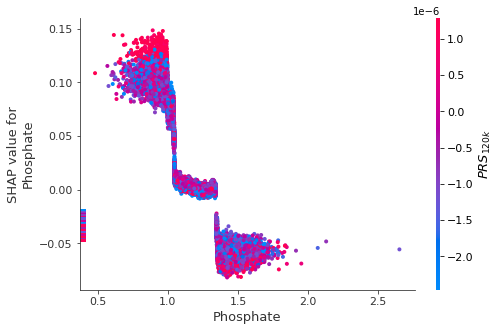

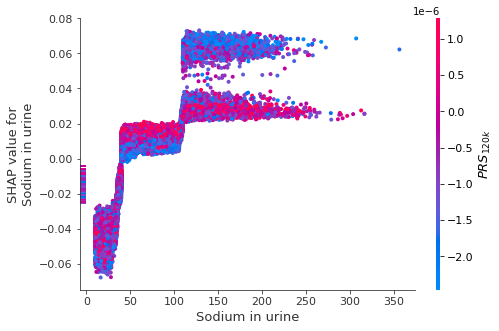

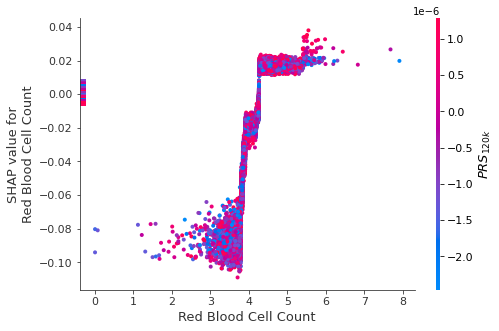

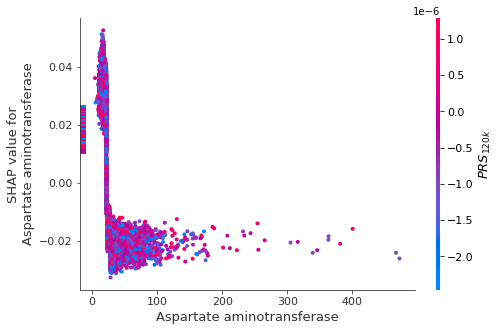

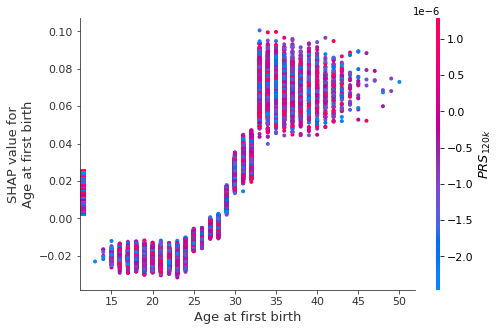

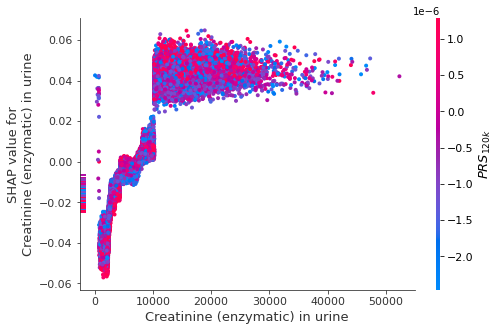

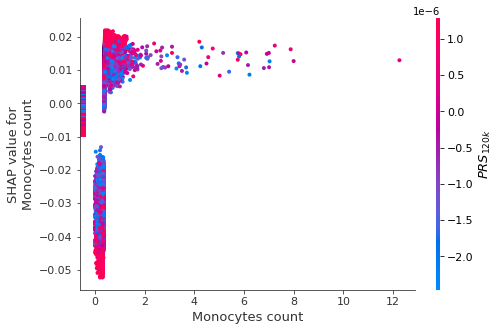

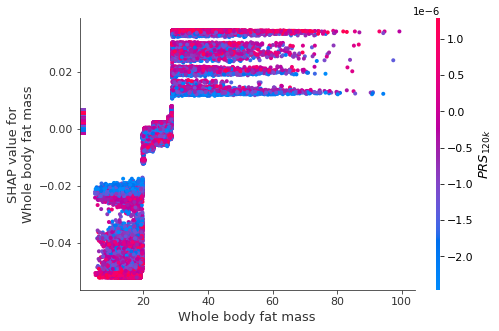

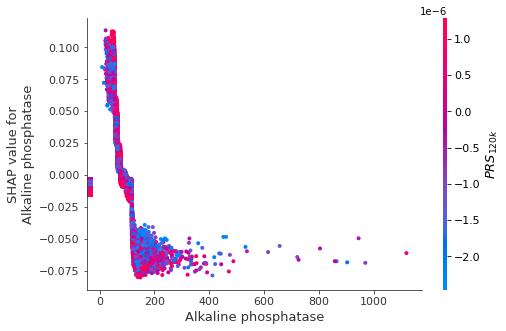

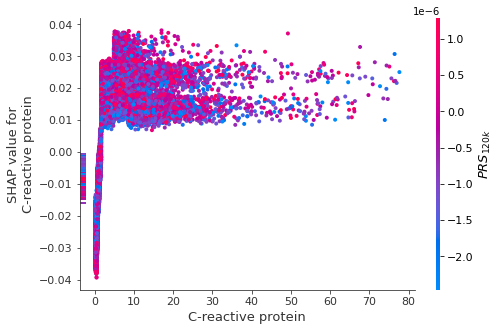

In [7]:
# Print interaction with 100k PRS

for name in feature_importance.Full_name[2:20]:
    shap.dependence_plot(str(name), shap_values, dtrain,feature_names=pretty_features,interaction_index='$PRS_{120k}$',show=False)
    f=plt.gcf()
    plt.savefig('K:\TEU\MLforBrCa\Stats_Outputs\SHAP Plots\SHAP_120kPRS_'+str(name)+'.png',bbox_inches='tight')


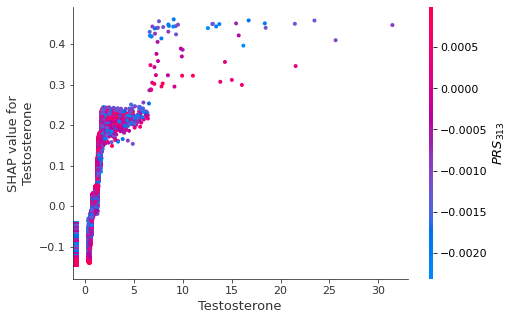

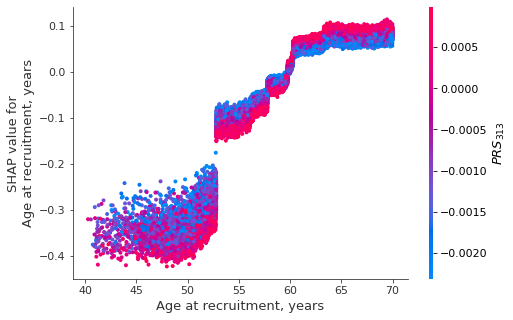

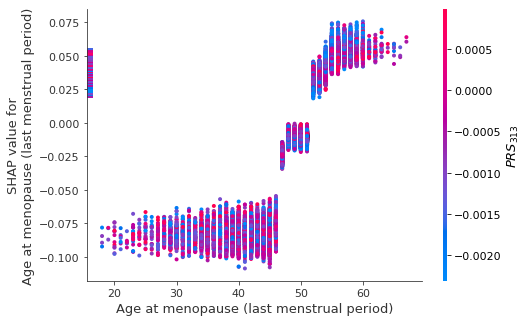

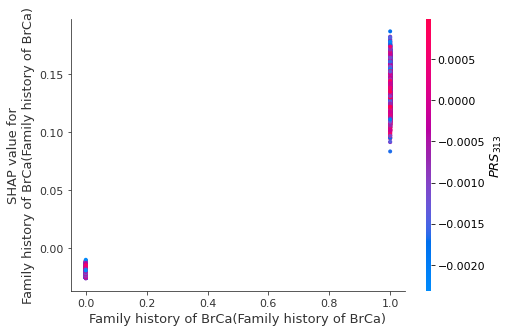

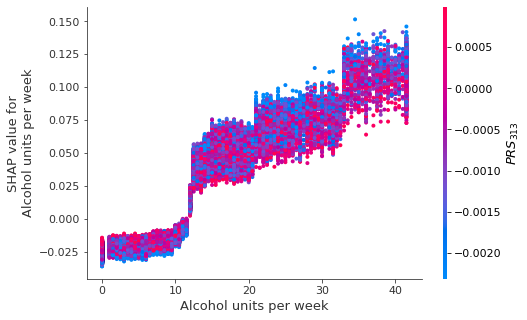

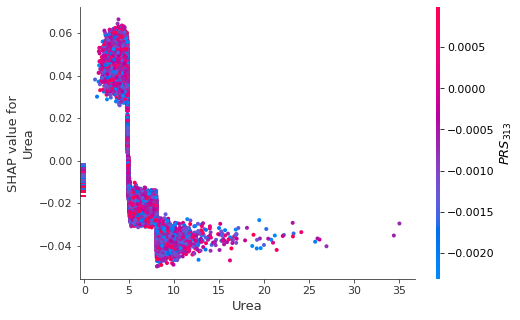

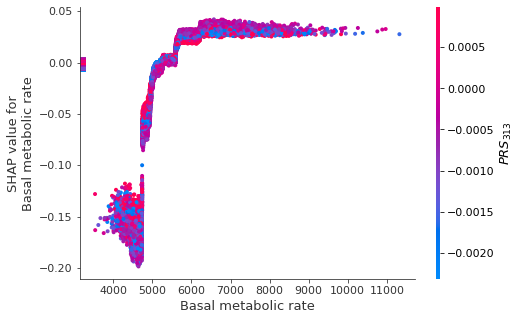

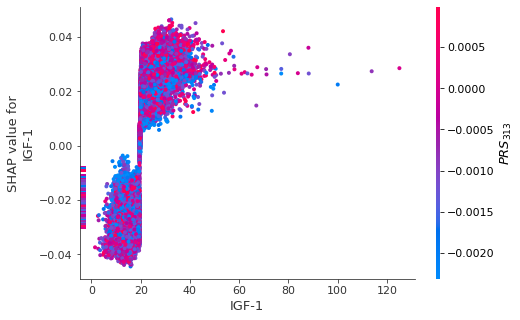

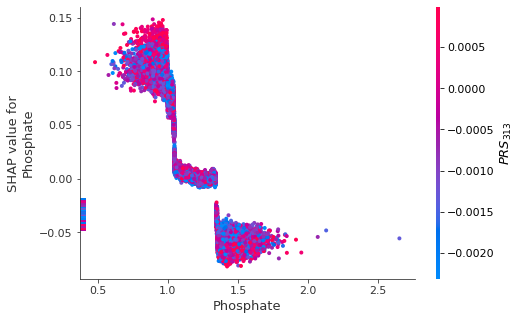

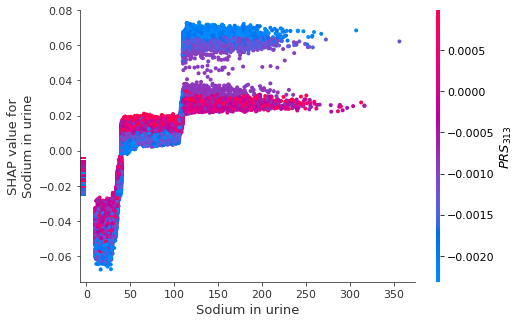

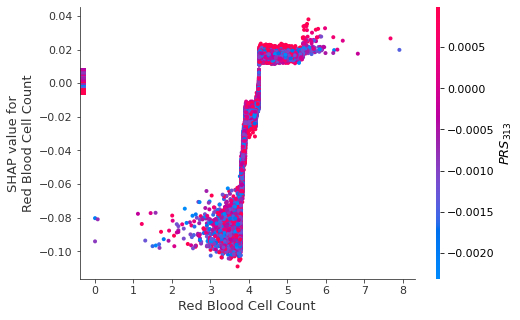

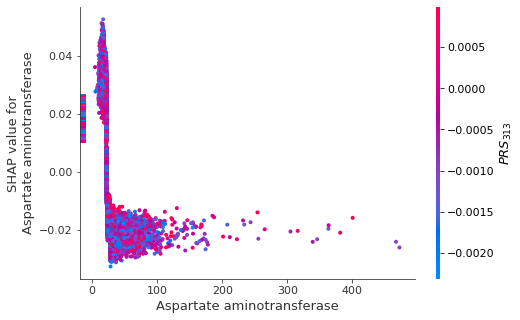

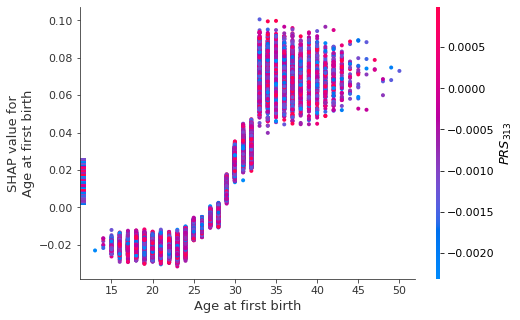

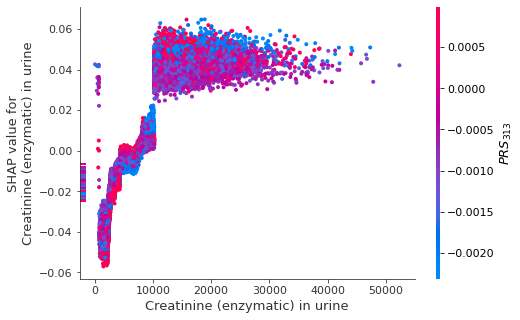

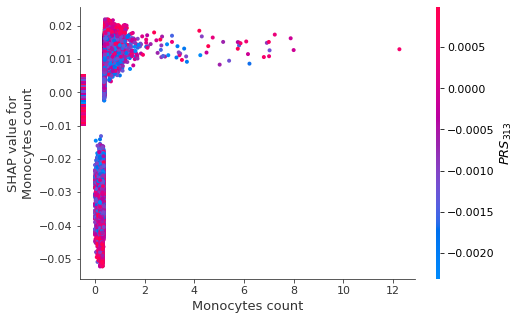

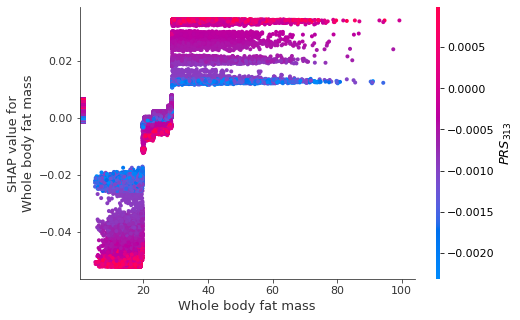

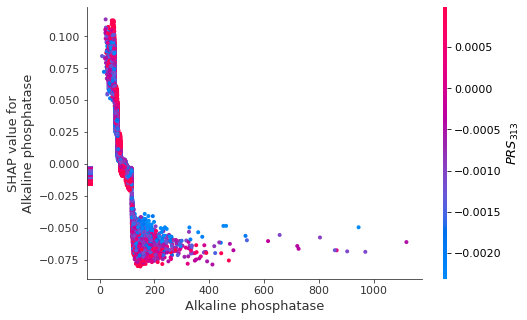

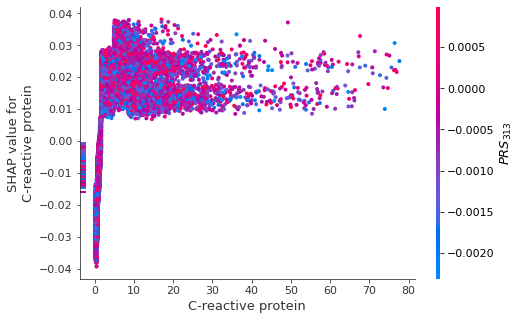

In [8]:
# Print interaction with 313 PRS

for name in feature_importance.Full_name[2:20]:
    shap.dependence_plot(str(name), shap_values, dtrain,feature_names=pretty_features,interaction_index="$PRS_{313}$",show=False)
    f=plt.gcf()
    plt.savefig('K:\TEU\MLforBrCa\Stats_Outputs\SHAP Plots\SHAP_313PRS_'+str(name)+'.png',bbox_inches='tight')


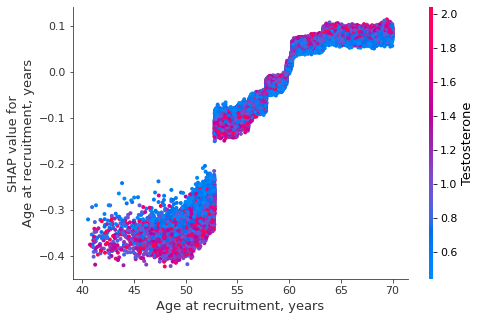

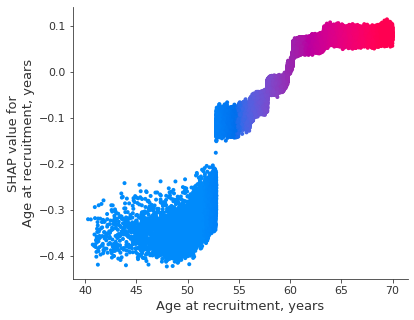

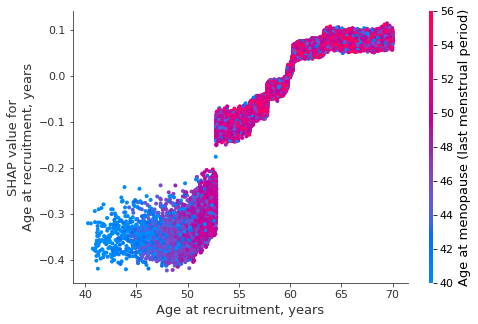

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


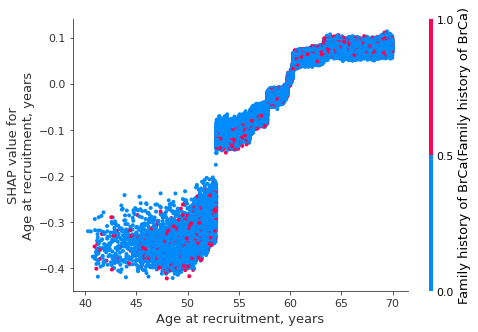

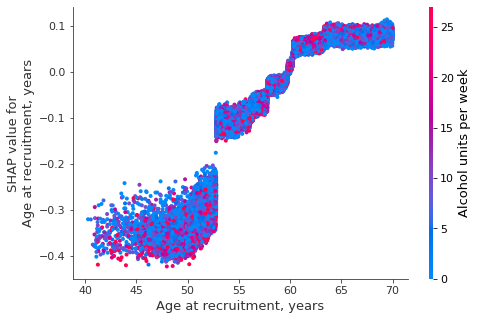

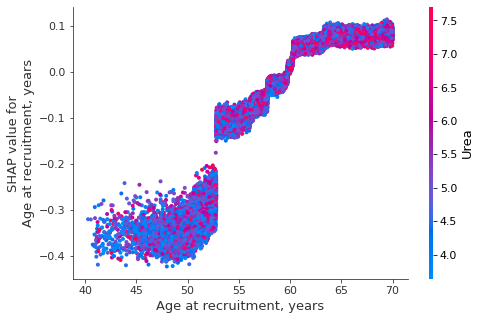

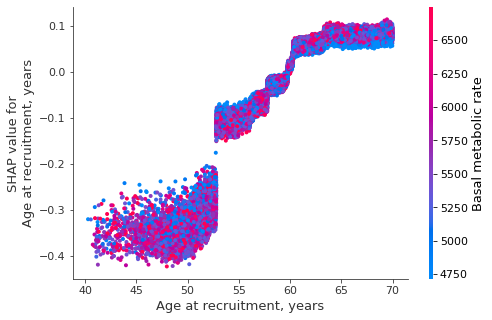

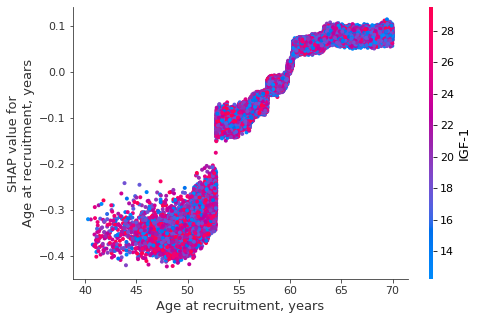

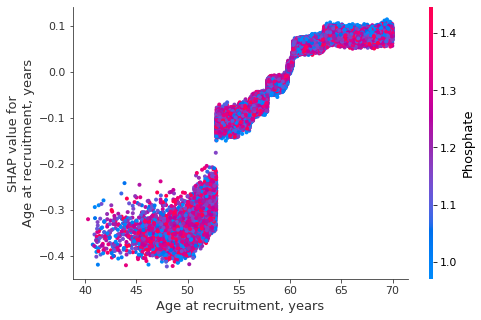

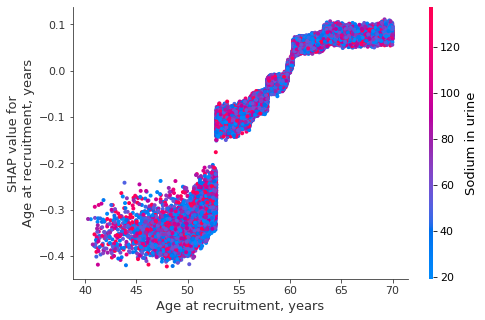

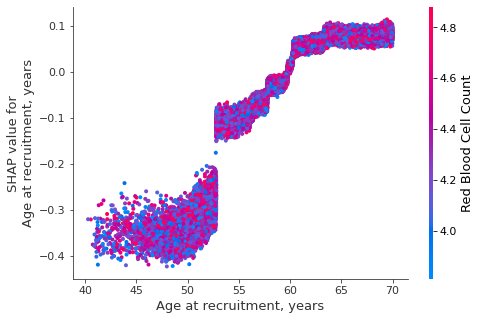

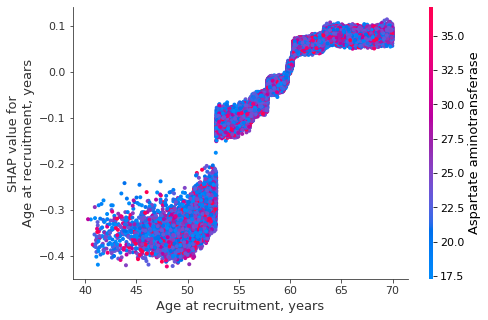

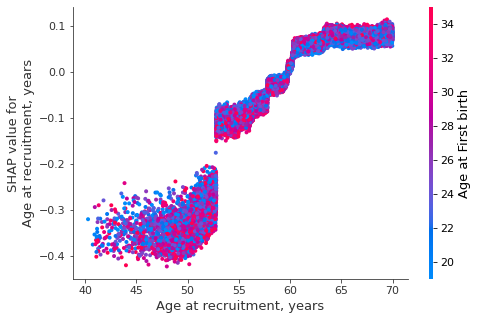

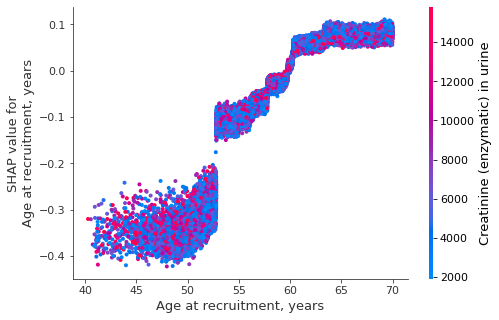

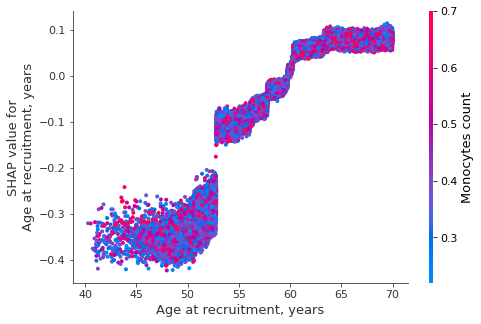

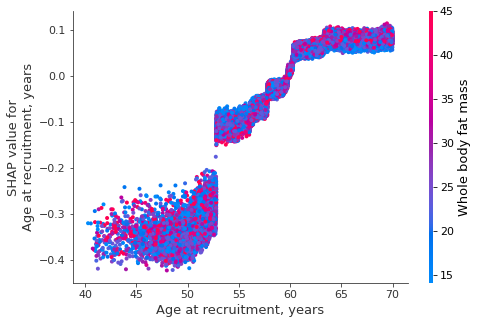

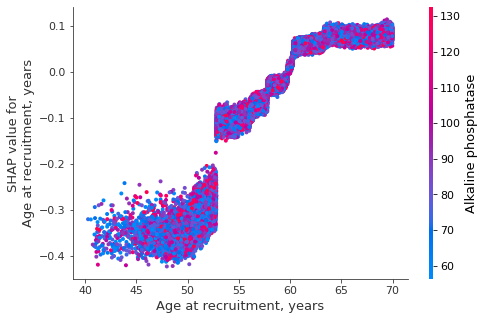

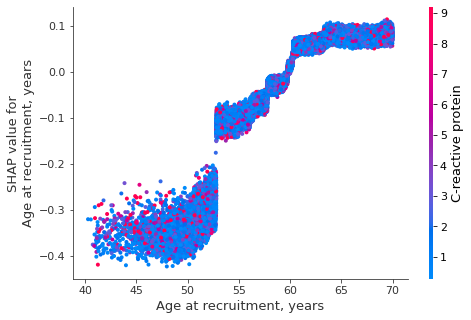

In [36]:
# Plot age interactions

for name in feature_importance.Full_name[2:20]:
    shap.dependence_plot('Age at recruitment, years', shap_values, dtrain,feature_names=pretty_features,interaction_index=str(name))

In [30]:
# Model performance on test set

# First make predictions on test set
Ypred=xgb_final.predict_proba(dtest)

# Compute AUC
test_auc=metrics.roc_auc_score(Ytest,Ypred[:,1])

print("AUC on test set: ",test_auc)

AUC on test set:  0.6679798800361427
